# Evaluation of the `HaGraD`-Optimizer with cifar10-Dataset

---

## Imports and Data-Preparation

In [1]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Hagrad custom optimizer
import sys; 
if "..\\" not in sys.path: sys.path.append("..\\")
from src.hagrad import Hagrad

In [2]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape  == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape  == (10000, 1)
y_test  = y_test.flatten()
y_train = y_train.flatten()

In [3]:
## Class number and sanity check
num_classes = 10
assert np.all(np.sort(np.unique(y_train)) == np.arange(num_classes))

## Normalizing and expanding dimensions for ConvLayers
def perpare_X_data(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float32) / 255.
    return(X)

X_train = perpare_X_data(X_train)
X_test  = perpare_X_data(X_test)

## convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

---

## Defining Model generating function

Convnet inspired by https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/.

In [4]:
def conv_NN(
    input_shape: tuple,
    num_classes: int,
    optimizer: keras.optimizers.Optimizer,
    print_summary: bool=False) -> keras.Model:

    ## Defining the Model with Sequential API
    model = keras.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.2),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),
            layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.3),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.3),
            layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.4),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.4),
            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    
    ## Compiling the Model using the given Optimizer
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(), 
        optimizer=optimizer, 
        metrics=["accuracy"])

    ## Optional: Print Model summary
    if print_summary: print(model.summary())

    return model


---

## Train the Network using different Optimizers

In [5]:
## Settings
batch_size  = 32
epochs      = 100
input_shape = X_train.shape[1:]

In [6]:
## Wrappers
def model_optimizer(optimizer):
    model = conv_NN(
        input_shape=input_shape, 
        num_classes=num_classes, 
        optimizer=optimizer, 
        print_summary=False)
    return model

def model_fit(model, verbose=2):
    fit = model.fit(
        X_train, y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(X_train, y_train), 
        verbose=verbose)
    return fit

#### Adam

In [7]:
keras.backend.clear_session()
model_adam = model_optimizer(keras.optimizers.Adam())
fit_adam = model_fit(model_adam)

Epoch 1/2
1563/1563 - 18s - loss: 2.0910 - accuracy: 0.2168 - val_loss: 1.6098 - val_accuracy: 0.3885
Epoch 2/2
1563/1563 - 14s - loss: 1.7364 - accuracy: 0.3462 - val_loss: 1.4347 - val_accuracy: 0.4690


### SGD

In [8]:
keras.backend.clear_session()
model_sgd = model_optimizer(keras.optimizers.SGD())
fit_sgd = model_fit(model_sgd)

Epoch 1/2
1563/1563 - 16s - loss: 2.1778 - accuracy: 0.1977 - val_loss: 1.7574 - val_accuracy: 0.3378
Epoch 2/2
1563/1563 - 14s - loss: 1.8764 - accuracy: 0.2842 - val_loss: 1.6233 - val_accuracy: 0.3893


### HaGraD

In [9]:
keras.backend.clear_session()
hagrad_optimizer = Hagrad()
print(hagrad_optimizer.get_config())
model_hagrad = model_optimizer(hagrad_optimizer)
fit_hagrad = model_fit(model_hagrad)

{'name': 'hagrad', 'epsilon': 1.0, 'gamma': 10.0, 'delta': 0.09090909090909091, 'kinetic_energy_gradient': 'Relativistic kinetic energy sqrt( ||p||^2 + 1 )-1 with gradient p/sqrt( ||p||^2 + 1 )'}
Epoch 1/2
1563/1563 - 25s - loss: 2.2292 - accuracy: 0.1964 - val_loss: 2.0047 - val_accuracy: 0.2809
Epoch 2/2
1563/1563 - 21s - loss: 1.8861 - accuracy: 0.3010 - val_loss: 1.7038 - val_accuracy: 0.3692


---

## Visualizing

Keras is evaluating the validation error at the end of each epoch. Therefore teh validation errors get shifted for the visualization:

In [10]:
epochs_arr = np.arange(epochs)
epochs_arr_val = epochs_arr + 1

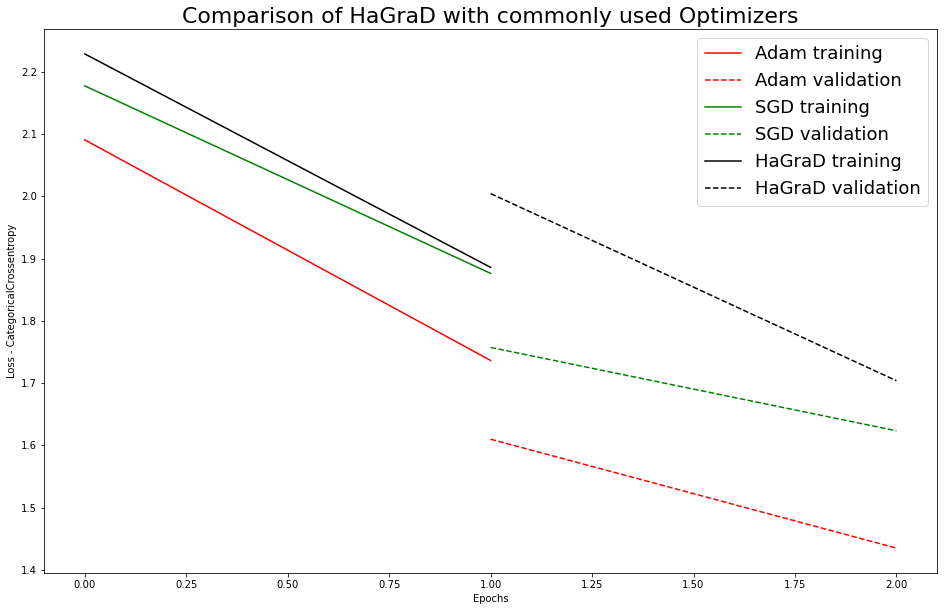

In [13]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Comparison of HaGraD with commonly used Optimizers", fontsize=22)
ax.plot(epochs_arr,     fit_adam.history['loss'],       "r-",  label="Adam training") 
ax.plot(epochs_arr_val, fit_adam.history['val_loss'],   "r--", label="Adam validation") 
ax.plot(epochs_arr,     fit_sgd.history['loss'],        "g-",  label="SGD training") 
ax.plot(epochs_arr_val, fit_sgd.history['val_loss'],    "g--", label="SGD validation") 
ax.plot(epochs_arr,     fit_hagrad.history['loss'],     "k-",  label="HaGraD training") 
ax.plot(epochs_arr_val, fit_hagrad.history['val_loss'], "k--", label="HaGraD validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
leg = ax.legend(frameon=True, fontsize=18)
plt.show()
plt.close()

---